In [11]:
!pip install pyspark

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

In [15]:
spark = SparkSession.builder.master("local").appName("Sales Data Analysis").getOrCreate()

In [17]:
spark

In [19]:
salesDF = spark.read.options(header=True, mode="DROPMALFORMED", inferSchema=True).\
    csv("supermarket_sales.csv", escape="\"")

In [21]:
salesDF = salesDF.na.drop()
salesDF = salesDF.na.drop(subset=['Quantity', 'Unit price'], thresh=1)

In [23]:
df = salesDF.select(col("Invoice ID").alias("invoiceID"),
                    col("Branch").alias("branch"),
                    col("City").alias("city"),
                    col("Customer type").alias("customer_type"),
                    col("Gender").alias("gender"),
                    col("Product line").alias("product_line"),
                    col("Unit price").alias("unit_price").cast("float"),
                    col("Quantity").alias("quantity").cast("integer"),
                    col("Date").alias("date"),
                    col("Time").alias("time"),
                    col("Payment").alias("payment_mode"),
                    col("Rating").alias("rating"))

In [25]:
df.printSchema()

root
 |-- invoiceID: string (nullable = true)
 |-- branch: string (nullable = true)
 |-- city: string (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- product_line: string (nullable = true)
 |-- unit_price: float (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- payment_mode: string (nullable = true)
 |-- rating: double (nullable = true)



In [27]:
print(f"There are {df.count()} records in the dataset.")

There are 1000 records in the dataset.


In [29]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [31]:
#Setting percentage of tax on different product lines
df = df.withColumn("tax", when(col("product_line") == 'Electronic accessories', 10)\
                   .when(col("product_line") == 'Health and beauty', 8)\
                   .when(col("product_line") == 'Fashion accessories', 12)\
                   .when(col("product_line") == 'Food and beverages', 5)\
                   .when(col("product_line") == 'Sports and travel', 14)
                   .otherwise(15))

In [33]:
df = df.withColumn("revenue", round(col("unit_price") * col("quantity"), 2))
df = df.withColumn("tax_percent", round((col("tax")/100) * col("revenue"), 2))
df = df.withColumn("total", round(col("revenue") + col("tax_percent"), 2))
df = df.withColumn("gross_income", round(col("total") - col("revenue"), 2))
df = df.withColumn("profit_percent1", round((col("gross_income")/col("total") * 100), 2))

In [35]:
def visualize(transform_df, plot_type='bar', hourly='N'):
    lst = []
    for field in transform_df.schema.fields:
        lst.append(field.name)

    pandas_df = transform_df.toPandas()

    if plot_type == 'bar' and hourly == 'N':
        plt.bar(pandas_df[lst[0]], pandas_df[lst[1]])
        plt.xticks(pandas_df[lst[0]], rotation=45, ha='right')

    elif plot_type == 'bar' and hourly == 'Y':
        pandas_df['time_frame_numeric'] = np.arange(transform_df.count())
        plt.bar(pandas_df['time_frame_numeric'], pandas_df[lst[1]], align='center', alpha=0.7)
        plt.xticks(pandas_df['time_frame_numeric'], pandas_df[lst[0]], rotation=45, ha='right')

    else:
        plt.plot(pandas_df[lst[0]], pandas_df[lst[1]])
        plt.xticks(pandas_df[lst[0]], rotation=45, ha='right')
        plt.grid(True)

    plt.xlabel(lst[0])
    plt.ylabel(lst[1])
    plt.tight_layout()
    plt.show()

In [37]:
#Number of orders per city
number_of_orders = df.groupBy("city").agg(count("invoiceID").alias("number_of_orders"))

In [39]:
number_of_orders.sort(desc("number_of_orders")).show()

+---------+----------------+
|     city|number_of_orders|
+---------+----------------+
|   Yangon|             340|
| Mandalay|             332|
|Naypyitaw|             328|
+---------+----------------+



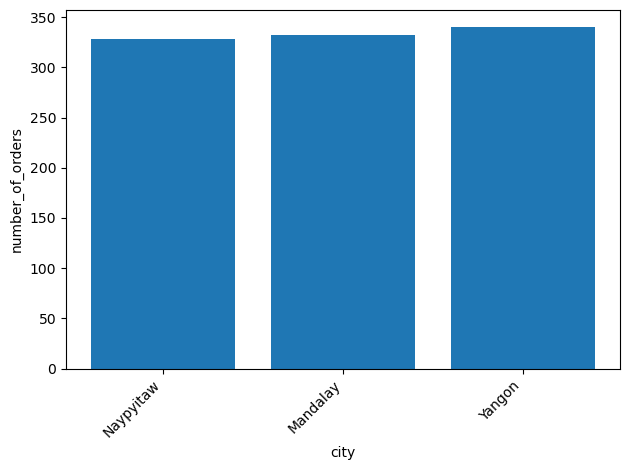

In [41]:
visualize(number_of_orders)

In [43]:
#Number of orders based on Gender
gen_based_order_count = df.groupBy("gender").agg(count("invoiceID").alias("gen_based_order_count"))

In [45]:
gen_based_order_count.sort(desc("gen_based_order_count")).show()

+------+---------------------+
|gender|gen_based_order_count|
+------+---------------------+
|Female|                  501|
|  Male|                  499|
+------+---------------------+



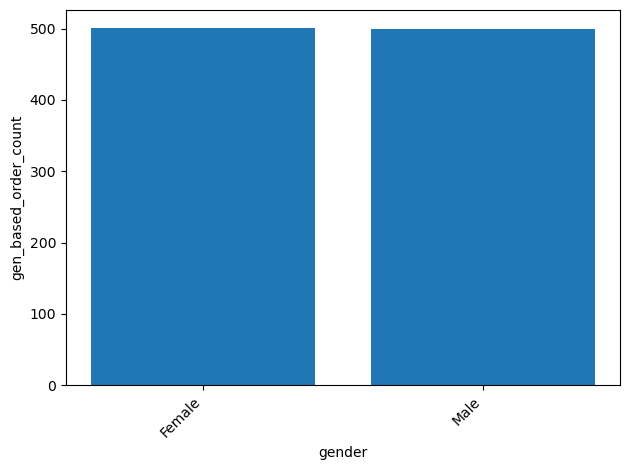

In [47]:
visualize(gen_based_order_count)

In [49]:
#Count the orders made by females for each product line
popular_prod_line_count_female = df.filter(col("gender") == "Female").groupBy("product_line").agg(count("invoiceID")
                                .alias("popular_prod_line_count_female"))

In [51]:
popular_prod_line_count_female.sort(desc("popular_prod_line_count_female")).show(truncate=False)

+----------------------+------------------------------+
|product_line          |popular_prod_line_count_female|
+----------------------+------------------------------+
|Fashion accessories   |96                            |
|Food and beverages    |90                            |
|Sports and travel     |88                            |
|Electronic accessories|84                            |
|Home and lifestyle    |79                            |
|Health and beauty     |64                            |
+----------------------+------------------------------+



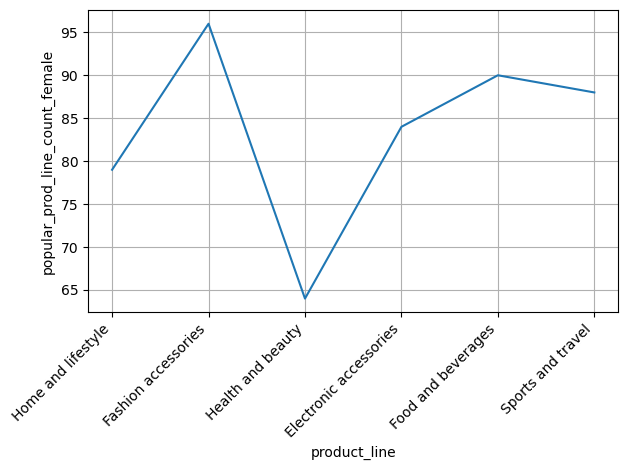

In [53]:
visualize(popular_prod_line_count_female, plot_type='line')

In [55]:
#Count the orders made by males for each product line
popular_prod_line_count_male = df.filter(col("gender") == "Male").groupBy("product_line").agg(count("invoiceID")
                                .alias("popular_prod_line_count_male"))

In [57]:
popular_prod_line_count_male.sort(desc("popular_prod_line_count_male")).show(truncate=False)

+----------------------+----------------------------+
|product_line          |popular_prod_line_count_male|
+----------------------+----------------------------+
|Health and beauty     |88                          |
|Electronic accessories|86                          |
|Food and beverages    |84                          |
|Fashion accessories   |82                          |
|Home and lifestyle    |81                          |
|Sports and travel     |78                          |
+----------------------+----------------------------+



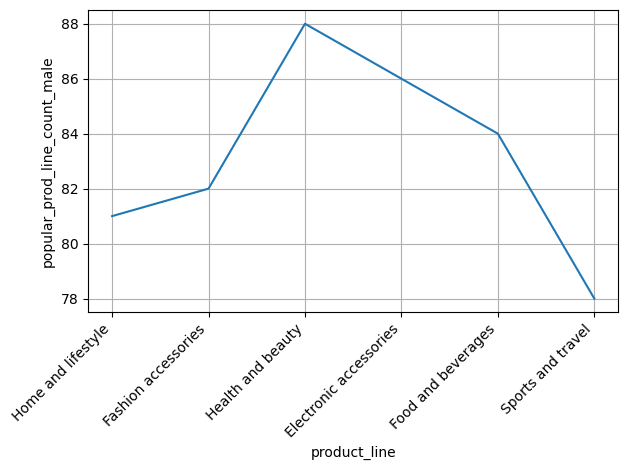

In [59]:
visualize(popular_prod_line_count_male, plot_type='line')

In [61]:
#Summary of total revenue generated, minimum, maximum and average rating for each product line
prod_line_summary = df.groupBy("product_line").agg(round(sum("total"), 2).alias("total_revenue"),
                               round(min("rating"), 2).alias("min_rating"),
                               round(max("rating"), 2).alias("max_rating"),
                               round(avg("rating"), 2).alias("avg_rating")).sort(desc("total_revenue"))

In [63]:
prod_line_summary.show(truncate=False)

+----------------------+-------------+----------+----------+----------+
|product_line          |total_revenue|min_rating|max_rating|avg_rating|
+----------------------+-------------+----------+----------+----------+
|Sports and travel     |59847.64     |4.0       |10.0      |6.92      |
|Home and lifestyle    |58991.63     |4.1       |9.9       |6.84      |
|Fashion accessories   |57926.25     |4.0       |9.9       |7.03      |
|Electronic accessories|56925.08     |4.0       |10.0      |6.92      |
|Food and beverages    |56144.88     |4.0       |9.9       |7.11      |
|Health and beauty     |50599.24     |4.0       |10.0      |7.0       |
+----------------------+-------------+----------+----------+----------+



In [65]:
#Average profit precent for each product line
avg_profit_percent = df.groupBy("product_line").agg(round(avg("profit_percent1"), 2).alias("avg_profit_percent"))

In [67]:
avg_profit_percent.orderBy(col("avg_profit_percent").desc()).show(truncate=False)

+----------------------+------------------+
|product_line          |avg_profit_percent|
+----------------------+------------------+
|Home and lifestyle    |13.04             |
|Sports and travel     |12.28             |
|Fashion accessories   |10.71             |
|Electronic accessories|9.09              |
|Health and beauty     |7.41              |
|Food and beverages    |4.76              |
+----------------------+------------------+



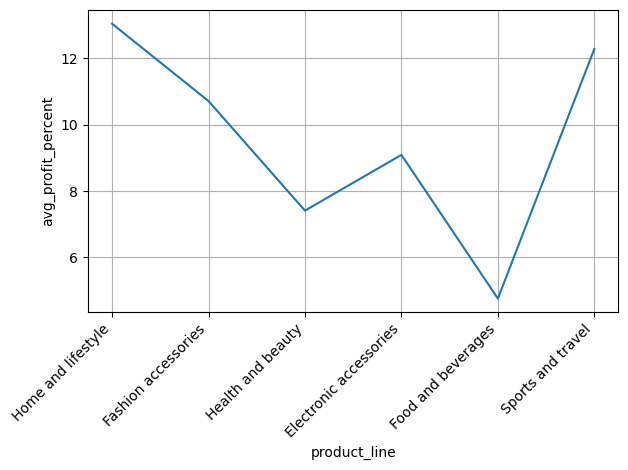

In [69]:
visualize(avg_profit_percent, plot_type='line')

In [71]:
#Average profit percent for each branch
branch_avg_profit_percent = df.groupBy("branch").\
    agg(round(avg("profit_percent1"), 2).alias("avg_profit_percent")).\
    orderBy(col("branch"))

In [73]:
branch_avg_profit_percent.orderBy(col("avg_profit_percent").desc()).show(truncate=False)

+------+------------------+
|branch|avg_profit_percent|
+------+------------------+
|A     |9.67              |
|B     |9.66              |
|C     |9.25              |
+------+------------------+



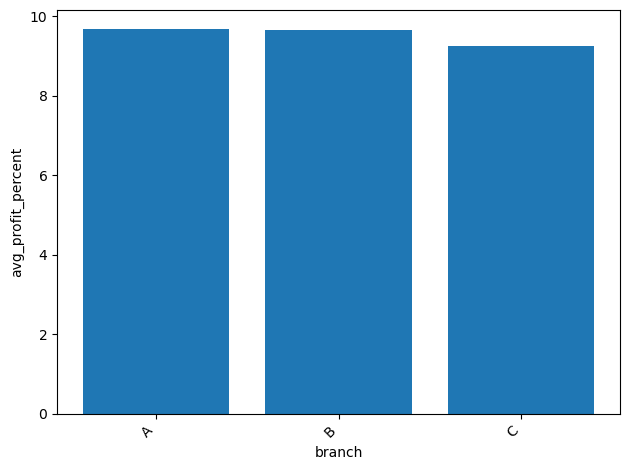

In [75]:
visualize(branch_avg_profit_percent)

In [77]:
#Average rating given by Males and Females
gen_based_avg_rating = df.groupBy("gender").agg(round(avg("rating"), 2).alias("avg_rating"))

In [79]:
gen_based_avg_rating.sort(desc("avg_rating")).show(truncate=False)

+------+----------+
|gender|avg_rating|
+------+----------+
|Male  |6.98      |
|Female|6.96      |
+------+----------+



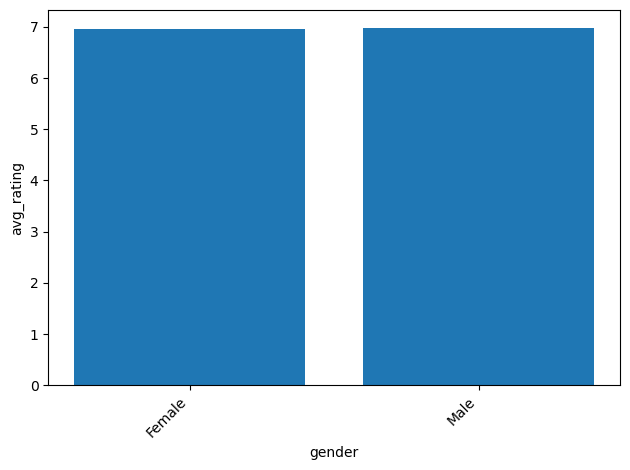

In [81]:
visualize(gen_based_avg_rating)

In [83]:
#Average rating given by females for each product line
gen_based_avg_prod_line_rating = df.filter(col("gender") == "Female").groupBy("product_line").\
    agg(round(avg("rating"), 2).alias("avg_prod_line_rating_female"))

In [85]:
gen_based_avg_prod_line_rating.sort(desc("avg_prod_line_rating_female")).show(truncate=False)

+----------------------+---------------------------+
|product_line          |avg_prod_line_rating_female|
+----------------------+---------------------------+
|Food and beverages    |7.2                        |
|Health and beauty     |7.15                       |
|Fashion accessories   |7.12                       |
|Electronic accessories|6.79                       |
|Sports and travel     |6.77                       |
|Home and lifestyle    |6.76                       |
+----------------------+---------------------------+



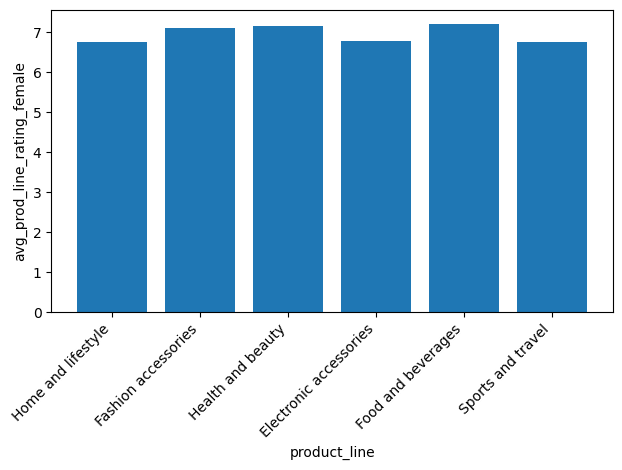

In [87]:
visualize(gen_based_avg_prod_line_rating)

In [89]:
#Average rating given by males for each product line
avg_prod_line_rating_male = df.filter(col("gender") == "Male").groupBy("product_line").\
    agg(round(avg("rating"), 2).alias("avg_prod_line_rating_male"))

In [91]:
avg_prod_line_rating_male.sort(desc("avg_prod_line_rating_male")).show(truncate=False)

+----------------------+-------------------------+
|product_line          |avg_prod_line_rating_male|
+----------------------+-------------------------+
|Sports and travel     |7.08                     |
|Electronic accessories|7.06                     |
|Food and beverages    |7.02                     |
|Fashion accessories   |6.92                     |
|Home and lifestyle    |6.91                     |
|Health and beauty     |6.9                      |
+----------------------+-------------------------+



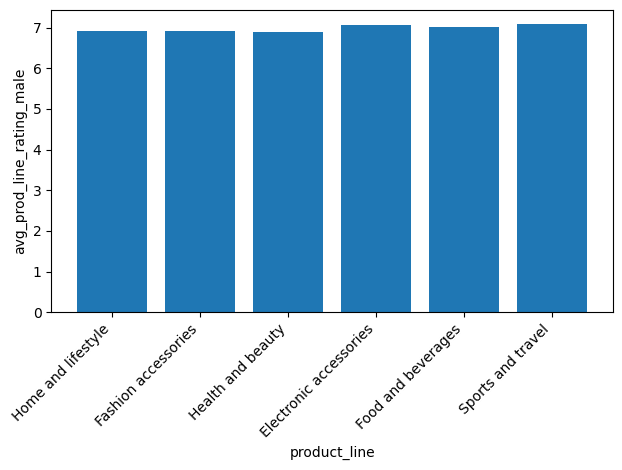

In [93]:
visualize(avg_prod_line_rating_male)

In [95]:
#Count of different types of customers
customer_type_count = df.groupBy("customer_type").agg(count("invoiceID").alias("count_of_type"))

In [97]:
customer_type_count.sort(desc("count_of_type")).show(truncate=False)

+-------------+-------------+
|customer_type|count_of_type|
+-------------+-------------+
|Member       |501          |
|Normal       |499          |
+-------------+-------------+



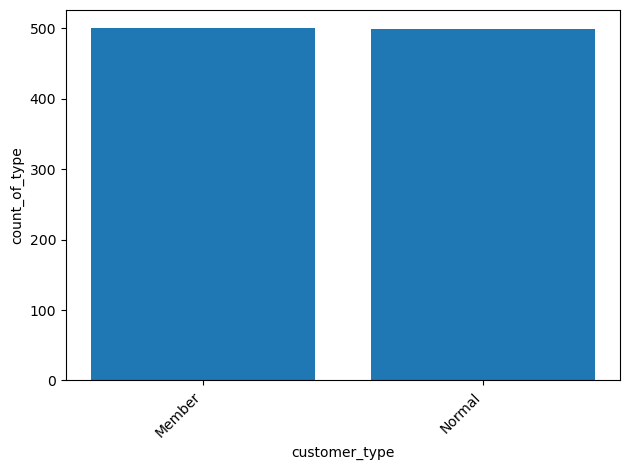

In [99]:
visualize(customer_type_count)

In [101]:
#Count of different types of female customers
female_customer_type_count = df.filter(col("gender") == "Female").groupBy("customer_type").\
    agg(count("invoiceID").alias("cust_type_female"))

In [103]:
female_customer_type_count.sort(desc("cust_type_female")).show(truncate=False)

+-------------+----------------+
|customer_type|cust_type_female|
+-------------+----------------+
|Member       |261             |
|Normal       |240             |
+-------------+----------------+



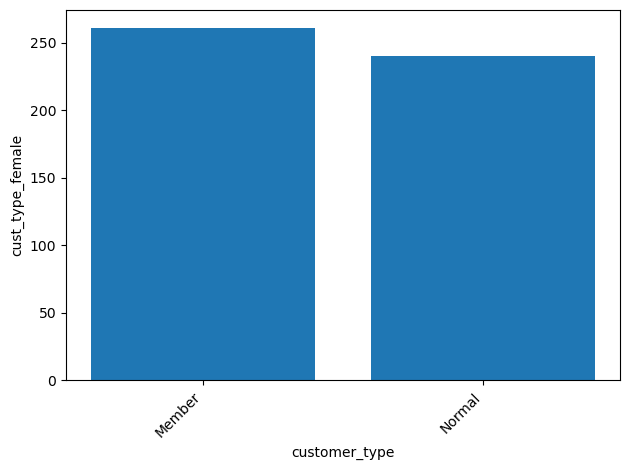

In [105]:
visualize(female_customer_type_count)

In [107]:
#Count of different types of male customers
male_customer_type_count = df.filter(col("gender") == "Male").groupBy("customer_type").\
    agg(count("invoiceID").alias("cust_type_male"))

In [109]:
male_customer_type_count.sort(desc("cust_type_male")).show(truncate=False)

+-------------+--------------+
|customer_type|cust_type_male|
+-------------+--------------+
|Normal       |259           |
|Member       |240           |
+-------------+--------------+



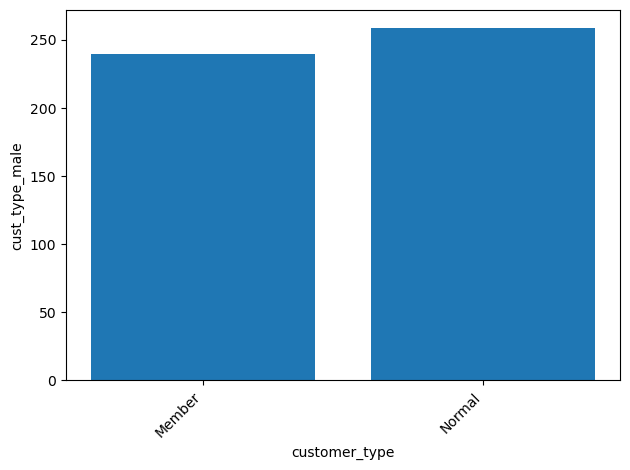

In [111]:
visualize(male_customer_type_count)

In [113]:
#Mode of payment (Ewallet, Cash, Credit Card) count
payment_mode_count = df.groupBy("payment_mode").agg(count("invoiceID").alias("count"))

In [115]:
payment_mode_count.sort(desc("count")).show(truncate=False)

+------------+-----+
|payment_mode|count|
+------------+-----+
|Ewallet     |345  |
|Cash        |344  |
|Credit card |311  |
+------------+-----+



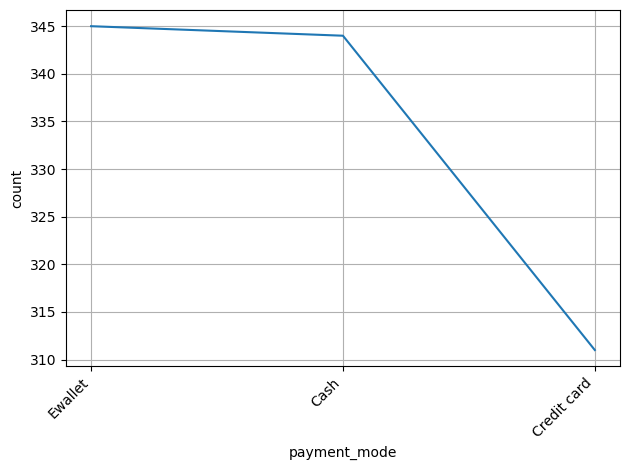

In [116]:
visualize(payment_mode_count, plot_type='line')

In [117]:
def hourly_calculations(spark, data, newFields):
    newData = []
    info = data.collect()
    if len(data.columns) == 3:
        for i in range(len(info)):
            a = str(info[i][0][0]).split(' ')[1]
            b = str(info[i][0][1]).split(' ')[1]
            c = info[i][1]
            d = info[i][2]

            newRow = (f"{a} - {b}", c, d)
            newData.append(newRow)
    else:
        for i in range(len(info)):
            a = str(info[i][0][0]).split(' ')[1]
            b = str(info[i][0][1]).split(' ')[1]
            c = info[i][1]

            newRow = (f"{a} - {b}", c)
            newData.append(newRow)

    newDF = spark.createDataFrame(newData, newFields)
    newDF.show()
    visualize(newDF, plot_type='line', hourly='Y')

In [118]:
def calculate(x):
    lst = []
    for field in x.schema.fields:
        lst.append(field.name)

    hourly_calculations(spark, x, lst)

In [119]:
#Number of Hourly transactions to determine the busiest time-window
hourly_transactions = df.groupBy(window(col("time"), windowDuration="1 hour").alias("time_frame"))\
                        .agg(count("invoiceID").alias("total_transactions")).sort(asc("time_frame"))

In [ ]:
calculate(hourly_transactions)

In [ ]:
#Hourly revenue generated
hourly_revenue_generated = df.groupBy(window(col("time"), windowDuration="1 hour").alias("time_frame"))\
                            .agg(round(sum("total"), 2).alias("revenue_generated")).sort(asc("time_frame"))

In [ ]:
calculate(hourly_revenue_generated)

In [ ]:
#Hourly Income generated
hourly_income_generated = df.groupBy(window(col("time"), windowDuration="1 hour").alias("time_frame"))\
                            .agg(round(sum("gross_income"), 2).alias("income_generated")).sort(asc("time_frame"))

In [ ]:
calculate(hourly_income_generated)